In [1]:
import sys

sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt

TIMEFRAME = '1h'
DATA_PATH = f'/mnt/c/Users/vmodg/source/repos/BeanRepos/crypto-pair-trading/data/{TIMEFRAME}'

In [4]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
 'ETHUSDT',
 'BCHUSDT',
 'XRPUSDT',
 'EOSUSDT',
 'LTCUSDT',
 'TRXUSDT',
 'ETCUSDT',
 'LINKUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'XMRUSDT',
 'DASHUSDT',
 'ZECUSDT',
 'XTZUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'ONTUSDT',
 'IOTAUSDT',
 'BATUSDT',
 'VETUSDT',
 'NEOUSDT',
 'QTUMUSDT',
 'IOSTUSDT',
 'THETAUSDT',
 'ALGOUSDT',
 'ZILUSDT',
 'KNCUSDT',
 'ZRXUSDT',
 'COMPUSDT',
 'OMGUSDT',
 'DOGEUSDT',
 'SXPUSDT',
 'KAVAUSDT',
 'BANDUSDT',
 'RLCUSDT',
 'WAVESUSDT',
 'MKRUSDT',
 'SNXUSDT',
 'DOTUSDT',
 'DEFIUSDT',
 'YFIUSDT',
 'BALUSDT',
 'CRVUSDT',
 'TRBUSDT',
 'RUNEUSDT',
 'SUSHIUSDT',
 'SRMUSDT',
 'EGLDUSDT',
 'SOLUSDT',
 'ICXUSDT',
 'STORJUSDT',
 'BLZUSDT',
 'UNIUSDT',
 'AVAXUSDT',
 'FTMUSDT',
 'HNTUSDT',
 'ENJUSDT',
 'FLMUSDT',
 'TOMOUSDT',
 'RENUSDT',
 'KSMUSDT',
 'NEARUSDT',
 'AAVEUSDT',
 'FILUSDT',
 'RSRUSDT',
 'LRCUSDT',
 'MATICUSDT',
 'OCEANUSDT',
 'CVCUSDT',
 'BELUSDT',
 'CTKUSDT',
 'AXSUSDT',
 'ALPHAUSDT',
 'ZENUSDT',
 'SKLUSDT',
 'GRTUSDT',
 '1INCHUSDT',
 'CHZUSDT',
 'SANDUSDT',
 'ANKRUSDT',
 'BTSUSDT',
 'LITUSDT',
 'UNFIUSDT',
 'REEFUSDT',
 'RVNUSDT',
 'SFPUSDT',
 'XEMUSDT',
 'BTCSTUSDT',
 'COTIUSDT',
 'CHRUSDT',
 'MANAUSDT',
 'ALICEUSDT',
 'HBARUSDT',
 'ONEUSDT',
 'LINAUSDT',
 'STMXUSDT',
 'DENTUSDT',
 'CELRUSDT',
 'HOTUSDT']
symbols = [s.replace('USDT', '-USDT') for s in symbols]

data = []
start_date = '2019-01-01'
test_end = '2020-12-01'
end_date = '2021-06-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        # df = df[df.index > '2022-01-01'].copy()
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC-USDT,ETH-USDT,BCH-USDT,XRP-USDT,EOS-USDT,LTC-USDT,ETC-USDT,LINK-USDT,XLM-USDT,ADA-USDT,...,ATOM-USDT,NEO-USDT,ALGO-USDT,DOT-USDT,SOL-USDT,UNI-USDT,AVAX-USDT,NEAR-USDT,MATIC-USDT,MANA-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2019-10-31 17:00:00,9.132687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 18:00:00,9.131267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 19:00:00,9.129168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 20:00:00,9.125883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 21:00:00,9.120086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def calculate_spread(df, pairs, hedge_ratio):
    spread = None
    for i, symbol in enumerate(pairs):
        if spread is None:
            spread = df[symbol] * hedge_ratio[i]
        else:
            spread += df[symbol] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread

In [5]:
pairs = ['ADA-USDT', 'XMR-USDT']
hedge_ratio = [2.110613783051293, -5.612196646086737]

spread = calculate_spread(df, pairs, hedge_ratio)

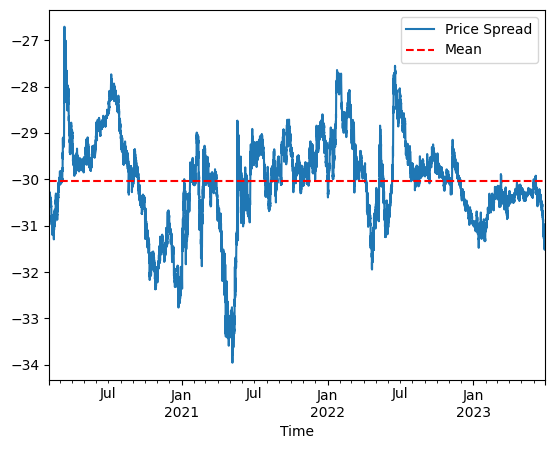

In [6]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])